In [1]:
# ! pip install --upgrade notebook
! pip install folium
! pip install geopy
! pip install geocoder
! pip install haversine
! pip install beautifulsoup4
# ! pip install seaborn --upgrade
# ! pip install plotly-express
# ! pip install nbconvert
# ! pip install lxml
# ! sudo apt install python3-lxml

## ! pip install pgeocode
## ! pip install reverse-geocode
## ! pip install pgeocode
# ! jupyter trust Toronto_AutoTheft.ipynb

In [2]:
# Importing standard libraires
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

## 1. Reading postal codes by Toronto borough

In [3]:
# Importing libraries
import requests
from bs4 import BeautifulSoup

# Making request and parsing 
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki = requests.get(url).text
# soup = BeautifulSoup(wiki, 'lxml')
soup = BeautifulSoup(wiki, "html.parser")


##### Finding table header and data

In [4]:
table = soup.find("table", attrs={"class": "wikitable sortable"})
header_data = table.tbody.find_all("tr")[0]
table_data = table.tbody.find_all("td")
postcode=[]
borough=[]
neighbourhood=[]
headings = []

##### Get all the headings of Lists

In [5]:
for td in header_data.find_all("th"):

    # remove any newlines and extra spaces from left and right
    headings.append(td.text.replace('\n', ' ').strip().replace(' ', '_'))

print(headings)

['Postal_Code', 'Borough', 'Neighbourhood']


##### Looping on table data and appending to lists.
###### Skip every 3 rows as all 3 columns of data are in one column

In [6]:
for k in range(0,540,3):
    postcode.append(table_data[k].text.replace('\n', '').strip())
    borough.append(table_data[k+1].text.replace('\n', '').strip())
    neighbourhood.append(table_data[k+2].text.replace('\n', '').strip())

##### Creating dataframe and dropping cases where Boroughs are unassigned

In [7]:
df_poscode = pd.DataFrame(zip(postcode,borough,neighbourhood),columns=headings)
df_poscode = df_poscode[df_poscode.Borough!='Not assigned'].reset_index(drop=True)
df_poscode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Postal_Code    103 non-null    object
 1   Borough        103 non-null    object
 2   Neighbourhood  103 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [8]:
df_poscode['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East York            5
York                 5
East Toronto         5
Mississauga          1
Name: Borough, dtype: int64

In [9]:
# Check to make sure postal codes are Unique
print("Postal codes are unique:",df_poscode.Postal_Code.is_unique)

Postal codes are unique: True


In [10]:
# Check that all Neighborhoods are Assigned
df_poscode[df_poscode.Neighbourhood=='Not assigned']

Empty DataFrame
Columns: [Postal_Code, Borough, Neighbourhood]
Index: []

In [11]:
df_poscode.head()

Postal_Code           Borough                                Neighbourhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

## 2. Downloading Geocodes

In [12]:
import geocoder

lats=[]
longs=[]
for i in df_poscode['Postal_Code']:
    lat_lng_coords=None
    while(lat_lng_coords is None):
        g=geocoder.arcgis('{}, Toronto, Ontario'.format(i))
        lat_lng_coords=g.latlng
    latitude=lat_lng_coords[0]
    longitude=lat_lng_coords[1]
    lats.append(latitude)
    longs.append(longitude)

df_geo = pd.concat([df_poscode['Postal_Code'],pd.DataFrame(lats,columns=['Latitude']),pd.DataFrame(longs,columns=['Longitude'])],axis=1)

In [13]:
# df_geo = pd.read_csv('toronto_geocodes.csv')
df_geo.head()

Postal_Code  Latitude  Longitude
0         M3A  43.75245  -79.32991
1         M4A  43.73057  -79.31306
2         M5A  43.65512  -79.36264
3         M6A  43.72327  -79.45042
4         M7A  43.66253  -79.39188

## 3. Merging the Latitude & Longitude data in to original dataframe

In [14]:
df_poscode = pd.merge(df_poscode,df_geo,left_on='Postal_Code', right_on='Postal_Code',suffixes=(None,None))

In [15]:
df_poscode.head()

Postal_Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

   Latitude  Longitude  
0  43.75245  -79.32991  
1  43.73057  -79.31306  
2  43.65512  -79.36264  
3  43.72327  -79.45042  
4  43.66253  -79.39188

## 4. Boroughs containing only Toronto and creating map

In [16]:
df_toronto = df_poscode[df_poscode['Borough'].str.contains('Toronto')].reset_index(drop=True)

In [17]:
df_toronto['Borough'].unique()  # 4 boroughs in toronto

array(['Downtown Toronto', 'East Toronto', 'West Toronto',
       'Central Toronto'], dtype=object)

In [18]:
import folium # map rendering library
latTOR =  43.677805
lngTOR = -79.402190

map_toronto = folium.Map(location=[latTOR, lngTOR], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 5. Getting top 100 venues around the four Toronto boroughs

In [19]:
## Function will return latitude/longitudes for up to 100 venues in a 500 radius for given postal code

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

def topvenues(postal_code,neighborhood_latitude,neighborhood_longitude):
    
    # Define Foursquare Credentials and Version
    CLIENT_ID = 'NI5DU0DH0ZB32IY0VLGVYQUHZCDAFXSL1ARMWPCR12EJYQTD' # your Foursquare ID
    CLIENT_SECRET = 'X041FK0ACUA0YVYFVLBYJMMKKGGZPCNA3N2ML05VMSZTLIZH' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius

     # create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
    
    req = requests.get(url).json()
    req = req['response']['groups'][0]['items']
    
    # flatten JSON
    nearby_venues = pd.json_normalize(req)
    
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.postalCode', 
                        'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]
    
    # function that extracts the category of the venue
    def get_category_type(req):
        try:
            categories_list = req['categories']
        except:
            categories_list = req['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
        
    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    
    # adjust postal code to 3 digit
    nearby_venues.columns = ['Name','Categories','PostalCode','Latitude','Longitude']
    nearby_venues['PostalCode3'] = postal_code
    results = nearby_venues[['Name','Categories','PostalCode','PostalCode3','Latitude','Longitude']]
    
    return results    

## 5.1. Building dataframe for all venues by category

In [20]:
df_venue = pd.DataFrame()
for pcde in df_toronto.Postal_Code.unique():   
    try:       
        cond = df_toronto[df_toronto.Postal_Code==pcde]
        lat = cond['Latitude'].values[0]
        lng = cond['Longitude'].values[0]
        tpven = topvenues(pcde,lat,lng)
        df_venue = pd.concat([df_venue, tpven],axis=0)
        #print(tpven)
 #       print('Latitude & Longitude are: {} & {}'.format(lat,lng))
    except:
        print('No venues for postal code: {}'.format(pcde))

No venues for postal code: M4R


In [21]:
# df_venue = pd.read_csv('toronto_venues.csv')
df_venue = df_venue.drop_duplicates(subset=['Name','Categories','Latitude','Longitude']).reset_index(drop=True)
df_venue.columns=['Name', 'Categories', 'PostalCode', 'PostalCode3', 'RestLat','RestLon']
df_venue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1176 non-null   object 
 1   Categories   1176 non-null   object 
 2   PostalCode   896 non-null    object 
 3   PostalCode3  1176 non-null   object 
 4   RestLat      1176 non-null   float64
 5   RestLon      1176 non-null   float64
dtypes: float64(2), object(4)
memory usage: 55.2+ KB


In [22]:
len(df_venue.Categories.unique())

224

## 5.2. Filtering for top restaurants

In [23]:
df_venue = df_venue[df_venue.Categories.str.contains("Restaurant")]
df_venue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 11 to 1175
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         289 non-null    object 
 1   Categories   289 non-null    object 
 2   PostalCode   229 non-null    object 
 3   PostalCode3  289 non-null    object 
 4   RestLat      289 non-null    float64
 5   RestLon      289 non-null    float64
dtypes: float64(2), object(4)
memory usage: 15.8+ KB


In [24]:
len(df_venue.Categories.unique())

43

##### Correcting postal code.
* Taking 3 digits from venue postal code if available
* Otherwise will take 3 digit from borough location


In [25]:
df_venue['Postal_Code'] = np.where(df_venue['PostalCode'].isna()==True,
                                                       df_venue['PostalCode3'],
                                                       df_venue['PostalCode'].str[:3])
df_venue.drop(['PostalCode','PostalCode3'],inplace=True, axis=1)  
df_venue = df_venue[['Name','Categories','Postal_Code','RestLat','RestLon']]
df_venue.reset_index(drop=False,inplace=True)

In [26]:
df_venue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        289 non-null    int64  
 1   Name         289 non-null    object 
 2   Categories   289 non-null    object 
 3   Postal_Code  289 non-null    object 
 4   RestLat      289 non-null    float64
 5   RestLon      289 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 13.7+ KB


In [27]:
import folium # map rendering library
latTOR =  43.677805
lngTOR = -79.402190

map_toronto = folium.Map(location=[latTOR, lngTOR], zoom_start=12)

# add neighbourhood markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

# add restaurants markers to map
for lat, lng, label in zip(df_venue['RestLat'], df_venue['RestLon'], df_venue['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='orange',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 6. Read in car theft data

##### The Auto Theft dataset is a subset of the Major Crime Indicators (MCI), covering car thefts reported from 2014 to 2019 in Toronto by location.
##### The data has been made publicly available by the Toronto Police Service. 
##### The locations are deliberate approximations of the nearest intersection to where the incident occurred.

In [28]:
# df_car_org = pd.read_csv('Toronto_Auto_Theft_2014_to_2019.csv')
# df_car = df_car_org.copy()

In [29]:
# The code was removed by Watson Studio for sharing.

##### Selecting only geo codes and getting unique counts

In [30]:
df_car = df_car[['Lat','Long']].groupby(['Lat','Long']).size().to_frame().reset_index().sort_values([0],ascending=False).reset_index(drop=True).reset_index()
df_car.columns = ['CarIDX','CarLat','CarLon','TheftCount']

In [31]:
df_car.head()

CarIDX     CarLat  CarLon  TheftCount
0       0  43.710690 -79.611         161
1       1  43.718128 -79.599         108
2       2  43.773617 -79.261          98
3       3  43.686760 -79.596          94
4       4  43.781639 -79.416          82

In [32]:
# df_car.TheftCount.sum() #23380

## 7. Merging restaurants and car theft data
#### Creating duplicates for calculating distances

In [33]:
df_venue_duplicates = pd.concat([df_venue]*len(df_car), ignore_index=True)
df_car_duplicates = pd.concat([df_car]*len(df_venue), ignore_index=True)
df_venue_duplicates = df_venue_duplicates.sort_values(['index'])

In [34]:
df_venue_duplicates.reset_index(drop=True,inplace=True)
df_venue_duplicates.index.set_names('key',inplace=True)
df_car_duplicates.index.set_names('key',inplace=True)
df_venue_thefts = df_venue_duplicates.merge(df_car_duplicates, left_on='key', right_on='key')
df_venue_thefts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605624 entries, 0 to 2605623
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   index        int64  
 1   Name         object 
 2   Categories   object 
 3   Postal_Code  object 
 4   RestLat      float64
 5   RestLon      float64
 6   CarIDX       int64  
 7   CarLat       float64
 8   CarLon       float64
 9   TheftCount   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 218.7+ MB


## 8. Calculating distance in KM between stakehouses and crime locations

##### Will use the the Haversine formula to find distance between two points
##### The Haversine formula calculates the shortest distance between two points on a sphere using their latitudes and longitudes measured along the surface.

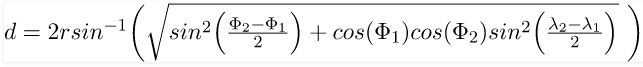

In [35]:
import numpy as np

def haversine_vectorize(lon1, lat1, lon2, lat2):

    # convert to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # calculate difference
    newlon = lon2 - lon1
    newlat = lat2 - lat1

    # apply haversine formula
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [36]:
df_venue_thefts['DistKM'] = haversine_vectorize(df_venue_thefts['RestLon'],df_venue_thefts['RestLat'],
                                                df_venue_thefts['CarLon'],df_venue_thefts['CarLat'])

## 9. Filter for crimes within a half KM around restaurant locations

In [37]:
df_venue_thefts = df_venue_thefts[df_venue_thefts['DistKM']<=0.5]

In [38]:
print('There are {} locations where {} vehicle thefts have occurred near a restauarnt in central Toronto'.format(len(df_venue_thefts),df_venue_thefts.TheftCount.sum()))

There are 8563 locations where 22109 vehicle thefts have occurred near a restauarnt in central Toronto


In [39]:
df_venue_thefts

index                       Name            Categories Postal_Code  \
key                                                                           
289         11  Mangia and Bevi Resto-Bar    Italian Restaurant         M5R   
342         11  Mangia and Bevi Resto-Bar    Italian Restaurant         M5R   
430         11  Mangia and Bevi Resto-Bar    Italian Restaurant         M5R   
537         11  Mangia and Bevi Resto-Bar    Italian Restaurant         M5R   
733         11  Mangia and Bevi Resto-Bar    Italian Restaurant         M5R   
...        ...                        ...                   ...         ...   
2603182   1175                 McDonald's  Fast Food Restaurant         M4Y   
2603208   1175                 McDonald's  Fast Food Restaurant         M4Y   
2603209   1175                 McDonald's  Fast Food Restaurant         M4Y   
2603218   1175                 McDonald's  Fast Food Restaurant         M4Y   
2603232   1175                 McDonald's  Fast Food Restaurant         M4Y   

           RestLat    RestLon  CarIDX     CarLat  CarLon  TheftCount    DistKM  
key                                                                             
289      43.652250 -79.366355     289  43.656502 -79.367           9  0.475370  
342      43.652250 -79.366355     342  43.650200 -79.362           8  0.417742  
430      43.652250 -79.366355     430  43.651569 -79.363           7  0.280167  
537      43.652250 -79.366355     537  43.654858 -79.368           6  0.318566  
733      43.652250 -79.366355     733  43.651466 -79.372           5  0.462125  
...            ...        ...     ...        ...     ...         ...       ...  
2603182  43.668854 -79.385962    6574  43.671925 -79.388           1  0.378548  
2603208  43.668854 -79.385962    6600  43.669975 -79.380           1  0.495186  
2603209  43.668854 -79.385962    6601  43.669975 -79.388           1  0.205844  
2603218  43.668854 -79.385962    6610  43.669670 -79.390           1  0.337015  
2603232  43.668854 -79.385962    6624  43.670326 -79.391           1  0.436766  

[8563 rows x 11 columns]

In [40]:
import folium # map rendering library
latTOR =  43.677805
lngTOR = -79.402190

map_toronto = folium.Map(location=[latTOR, lngTOR], zoom_start=12)

# add neighbourhood markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

# add restaurants markers to map
for lat, lng, label in zip(df_venue['RestLat'], df_venue['RestLon'], df_venue['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='orange',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

# add car theft markers to map
for lat, lng in zip(df_venue_thefts['CarLat'], df_venue_thefts['CarLon']): #, label , df_car['Name']
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        # popup=label,
        color='red',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 10. Aggregate total vehicle thefts by stakehouse and select the restaurant with the lowest number of thefts

In [41]:
df_venue_thefts_agg = df_venue_thefts[['Name','TheftCount']].groupby('Name').sum().sort_values(by='TheftCount').reset_index()

In [42]:
best_rest_nm = df_venue_thefts_agg['Name'][0]

crime_loc = df_venue_thefts.loc[df_venue_thefts['Name']==best_rest_nm,['CarLat','CarLon']]
crime_label = '# Thefts=' + df_venue_thefts.loc[df_venue_thefts['Name']==best_rest_nm,['TheftCount']].astype(str)
best_rest_loc = df_venue_thefts.loc[df_venue_thefts['Name']==best_rest_nm,['RestLat','RestLon']].drop_duplicates()
best_rest_lat = best_rest_loc.iloc[0]['RestLat']
best_rest_lon = best_rest_loc.iloc[0]['RestLon']

best_rest_ct = df_venue_thefts_agg['TheftCount'][0]
locations = crime_loc[['CarLat','CarLon']]
locationlist = locations.values.tolist()
print('The best restaurant with the lowest number of car thefts is: {}.\nThere were a total of {} car thefts in a half KM radius around restaurant.\nSpanning {} locations in Toronto, reported over the past five years.'.format(best_rest_nm,best_rest_ct,len(crime_loc)))

The best restaurant with the lowest number of car thefts is: Seaspray Restaurant.
There were a total of 11 car thefts in a half KM radius around restaurant.
Spanning 7 locations in Toronto, reported over the past five years.


## 11. Finally, mapping the car theft locations around the preferred restaurant

In [43]:
import folium # map rendering library
from folium.plugins import MarkerCluster
latTOR =  43.667872
lngTOR = -79.359318

map_toronto = folium.Map(location=[latTOR, lngTOR], zoom_start=12.5)

# add neighbourhood markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

# add restaurant location to map
label = folium.Popup(best_rest_nm, parse_html=True)
folium.CircleMarker(
    [best_rest_lat, best_rest_lon],
    radius=8,
    popup=label,
    color='green',
    fill=True,
    fill_color='#31cc77',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)

# add car theft markers to map
for lat, lng in zip(crime_loc['CarLat'], crime_loc['CarLon']): #, label , df_car['Name']
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        # popup=label,
        color='red',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

# marker_cluster = MarkerCluster().add_to(map_toronto)

# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point], popup=crime_label.iloc[point]['TheftCount']).add_to(marker_cluster)
map_toronto

## Bonus Analysis: Car thefts around airports & Late car theft reportings

#### Top 15 theft locations in Toronto

In [44]:
topTheftLoc = df_car.loc[0:14]

In [45]:
df_car

CarIDX     CarLat  CarLon  TheftCount
0          0  43.710690 -79.611         161
1          1  43.718128 -79.599         108
2          2  43.773617 -79.261          98
3          3  43.686760 -79.596          94
4          4  43.781639 -79.416          82
...      ...        ...     ...         ...
9011    9011  43.697460 -79.434           1
9012    9012  43.697422 -79.310           1
9013    9013  43.697376 -79.396           1
9014    9014  43.697315 -79.454           1
9015    9015  43.850788 -79.190           1

[9016 rows x 4 columns]

In [46]:
theftLabel = "Theft="+topTheftLoc['TheftCount'].astype(str)

In [47]:
import folium # map rendering library

latTOR =  43.715535
lngTOR = -79.555778

map_toronto = folium.Map(location=[latTOR, lngTOR], zoom_start=11)

# add markers to map
for lat, lng, label in zip(topTheftLoc['CarLat'], topTheftLoc['CarLon'], theftLabel):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)   
       
map_toronto

In [48]:
theftcount_top15 = topTheftLoc['TheftCount'].sum()
theftcount_agg = df_car['TheftCount'].sum()
print("There were {} car thefts in the top 15 theft locations. This represent {}% of the total theft count in Toronto. It's interesting to see a large proportion concentrated around airports!!".format(theftcount_top15, round(theftcount_top15/theftcount_agg*100,1)))

There were 1119 car thefts in the top 15 theft locations. This represent 4.8% of the total theft count in Toronto. It's interesting to see a large proportion concentrated around airports!!


#### Checking closer around the two main airports

In [49]:
data = { 'Airport': ['Pearson','Downsview'],
             'lat': [43.6777, 43.7390],
             'lng': [-79.6248,-79.4593] }
df_airport = pd.DataFrame(data)
df_airport

Airport      lat      lng
0    Pearson  43.6777 -79.6248
1  Downsview  43.7390 -79.4593

In [50]:
df_airport_thefts_org = pd.DataFrame()
for j in range(0,2):
    tmp = pd.concat([df_airport.loc[j].to_frame().transpose()]*len(df_car), ignore_index=True).join(df_car)
    df_airport_thefts_org = pd.concat([df_airport_thefts_org, tmp],axis=0)

In [51]:
df_airport_thefts_org[["lat", "lng"]] = df_airport_thefts_org[["lat", "lng"]].apply(pd.to_numeric)

In [52]:
df_airport_thefts_org['DistKM'] = haversine_vectorize(df_airport_thefts_org['lng'],df_airport_thefts_org['lat'],
                                                      df_airport_thefts_org['CarLon'],df_airport_thefts_org['CarLat'])

#### Scanning within 5KM

In [53]:
df_airport_thefts_5KM = df_airport_thefts_org[df_airport_thefts_org['DistKM']<=5]
df_airport_thefts_5KM.TheftCount.sum()

4881

In [54]:
df_airport_thefts_5KM.groupby('Airport').count()

lat   lng  CarIDX  CarLat  CarLon  TheftCount  DistKM
Airport                                                          
Downsview  1299  1299    1299    1299    1299        1299    1299
Pearson     183   183     183     183     183         183     183

In [55]:
df_airport_thefts_5KM_agg = df_airport_thefts_5KM[['Airport','TheftCount']].groupby('Airport').sum().sort_values(by='TheftCount').reset_index()
df_airport_thefts_5KM_agg = df_airport_thefts_5KM_agg.append(pd.DataFrame([['Total',df_airport_thefts_5KM_agg['TheftCount'].sum()]],columns=['Airport','TheftCount']),ignore_index=True).reset_index(drop=True)
# df_airport_thefts_5KM_agg['PctShr'] = round(df_airport_thefts_5KM_agg['TheftCount']/df_airport_thefts_5KM_agg['TheftCount'][2]*100,1)
df_airport_thefts_5KM_agg['PctShrToT'] = round(df_airport_thefts_5KM_agg['TheftCount']/df_airport_thefts_5KM_agg['TheftCount'][2]*100,1)
df_airport_thefts_5KM_agg

Airport  TheftCount  PctShrToT
0    Pearson        1206       24.7
1  Downsview        3675       75.3
2      Total        4881      100.0

In [56]:
import folium # map rendering library

latTOR =  43.715535
lngTOR = -79.555778

map_toronto = folium.Map(location=[latTOR, lngTOR], zoom_start=11.4)

# add airport markers to map
folium.Circle(
    radius=5200,
    location=[43.6777,-79.6248],
    popup="Pearson Airport",
    color="crimson",
    fill=False).add_to(map_toronto)

folium.Circle(
    radius=5200,
    location=[43.7390,-79.4593],
    popup="Downsview Airport",
    color="crimson",
    fill=False).add_to(map_toronto)
    
# add car theft markers to map
for lat, lng in zip(df_airport_thefts_5KM['CarLat'], df_airport_thefts_5KM['CarLon']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        # popup=label,
        color='red',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)   
       
map_toronto

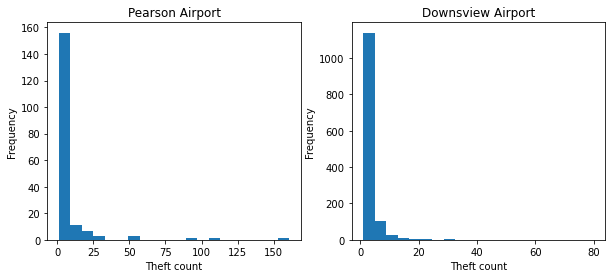

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
# ax1 = fig.add_axes([0.1, 0.1, 0.6, 0.75])
# ax2 = fig.add_axes([0.1, 0.1, 0.6, 0.75])

n1, bins, patches = ax1.hist(df_airport_thefts_5KM[df_airport_thefts_5KM.Airport=='Pearson']['TheftCount'],bins=20)
ax1.set_xlabel('Theft count')
ax1.set_ylabel('Frequency')
ax1.title.set_text('Pearson Airport')

n2, bins, patches = ax2.hist(df_airport_thefts_5KM[df_airport_thefts_5KM.Airport=='Downsview']['TheftCount'],bins=20)
ax2.set_xlabel('Theft count')
ax2.set_ylabel('Frequency')
ax2.title.set_text('Downsview Airport')

In [58]:
# 4881/23380*100 #20.87681779298546

#### Now filtering for thefts around 5KM from airports but having a total theft count of at least 30 or more

In [59]:
df_airport_thefts = df_airport_thefts_org[(df_airport_thefts_org['DistKM']<=5) & (df_airport_thefts_org['TheftCount']>=30)]

In [60]:
theftcount_aiport = df_airport_thefts['TheftCount'].sum()
print("There were {} car thefts around airports. This represent {}% of the total theft count in Toronto.".format(theftcount_aiport, round(theftcount_aiport/theftcount_agg*100,1)))

There were 818 car thefts around airports. This represent 3.5% of the total theft count in Toronto.


In [61]:
theftLabel = "Theft=" + df_airport_thefts['TheftCount'].astype(str)

In [62]:
df_airport_thefts_agg = df_airport_thefts[['Airport','TheftCount']].groupby('Airport').sum().sort_values(by='TheftCount').reset_index()

In [63]:
df_airport_thefts_agg = df_airport_thefts_agg.append(pd.DataFrame([['Total',df_airport_thefts_agg['TheftCount'].sum()]],columns=['Airport','TheftCount']),ignore_index=True).reset_index(drop=True)
df_airport_thefts_agg['%Theft'] = round(df_airport_thefts_agg['TheftCount']/df_airport_thefts_agg['TheftCount'][2]*100,1)
df_airport_thefts_agg['%TheftsToronto'] = round(df_airport_thefts_agg['TheftCount']/theftcount_agg*100,1)
df_airport_thefts_agg

Airport  TheftCount  %Theft  %TheftsToronto
0  Downsview         302    36.9             1.3
1    Pearson         516    63.1             2.2
2      Total         818   100.0             3.5

In [64]:
airport_loc = df_airport[['lat','lng']].values.tolist()

In [65]:
import folium # map rendering library

latTOR =  43.715535
lngTOR = -79.555778

map_toronto = folium.Map(location=[latTOR, lngTOR], zoom_start=11.4)

# add markers to map
for lat, lng, label in zip(df_airport_thefts['CarLat'], df_airport_thefts['CarLon'], theftLabel):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)   

    folium.Circle(
        radius=5200,
        location=[43.6777,-79.6248],
        popup="Pearson Airport",
        color="crimson",
        fill=False).add_to(map_toronto)

    folium.Circle(
        radius=5200,
        location=[43.7390,-79.4593],
        popup="Downsville Airport",
        color="crimson",
        fill=False).add_to(map_toronto)
        
map_toronto

In [66]:
# # Define functions to download as CSV or Excel
# from IPython.display import HTML
# import pandas as pd
# import base64, io

# # Download as CSV: data frame, optional title and filename
# def create_download_link_csv(df, title = "Download CSV file", filename = "data.csv"):  
#     # generate in-memory CSV, then base64-encode it
#     csv = df.to_csv(index=False)
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)

# # create_download_link_csv(df_airport_thefts,"Download my data","toronto_airports.csv")
# create_download_link_csv(df_venue,"Download my data","toronto_venues.csv")